#### Reading of the manual anotated files from Johannes

Some of the annotations are 128 some are 256. The annotations are mostly done on 256 scale. So we currently upscale to 256x256, for both the manual annotations and the dcim images.

In [222]:
import struct
import numpy as np
import cv2

# Read the manual annotations and scales them down to (128,128)
def readAnotations(pathFileName, skip):
    global f, numByte, fileNameRead, byte, width, decoded, height, allPixel, slices
    f = open(pathFileName, "rb")
    try:
        numByte = 0
        fileNameRead = ""
        byte = f.read(1)
        while byte != "":
            byte = f.read(1)
            if numByte < skip: #The filename is coded in the binary file, hence we skip a few bytes
                fileNameRead += byte
            else:
                fileNameRead += byte
                width = decoded = struct.unpack('>I', f.read(4))[0]  # This is magic, we have big-endian coding
                height = decoded = struct.unpack('>I', f.read(4))[0]
                #print("Read header of [" + fileNameRead + "] width = , " + str(width) + " height=" + str(height))
                allPixel = np.fromfile(f, dtype='>I', count=-1, sep='')
                slices = len(allPixel) / (width * height) 
                # Reshaping and downscaling
                l = np.sqrt(len(allPixel))
                img = np.reshape(allPixel / 256.0, (l,l))
                if l < 256:
                    dd = cv2.resize(img,(256,256))
                else:
                    dd = img
                Y = np.reshape(dd * 256, (1, 256, 256))
                print("---->  " + str(allPixel.max()) + "  " + str(np.unique(allPixel)) + " " + str(l))
                f.close()
                return Y,l
            numByte += 1
    finally:
        f.close()

#### This is just for testing readAnnotation

---->  0  [0] 256.0
3SUIUNLJQMTGZRVTJM7LWTPHDA======_ep2d_diff_3scan_p3_m128_ADC_3_20.dcm.iov (1, 128, 128) 0.0
---->  0  [0] 256.0
3SUIUNLJQMTGZRVTJM7LWTPHDA======_ep2d_diff_3scan_p3_m128_ADC_3_4.dcm.iov (1, 128, 128) 0.0
---->  2  [0 1 2] 256.0
3SUIUNLJQMTGZRVTJM7LWTPHDA======_ep2d_diff_3scan_p3_m128_ADC_3_10.dcm.iov (1, 128, 128) 2.0
---->  2  [0 1 2] 256.0
3SUIUNLJQMTGZRVTJM7LWTPHDA======_ep2d_diff_3scan_p3_m128_ADC_3_14.dcm.iov (1, 128, 128) 2.0
---->  2  [0 1 2] 256.0
3SUIUNLJQMTGZRVTJM7LWTPHDA======_ep2d_diff_3scan_p3_m128_ADC_3_11.dcm.iov (1, 128, 128) 2.0
---->  2  [0 1 2] 256.0
3SUIUNLJQMTGZRVTJM7LWTPHDA======_ep2d_diff_3scan_p3_m128_ADC_3_13.dcm.iov (1, 128, 128) 2.0
---->  0  [0] 256.0
3SUIUNLJQMTGZRVTJM7LWTPHDA======_ep2d_diff_3scan_p3_m128_ADC_3_9.dcm.iov (1, 128, 128) 0.0
---->  0  [0] 256.0
3SUIUNLJQMTGZRVTJM7LWTPHDA======_ep2d_diff_3scan_p3_m128_ADC_3_19.dcm.iov (1, 128, 128) 0.0
---->  0  [0] 256.0
3SUIUNLJQMTGZRVTJM7LWTPHDA======_ep2d_diff_3scan_p3_m128_ADC_3_6.dcm.i

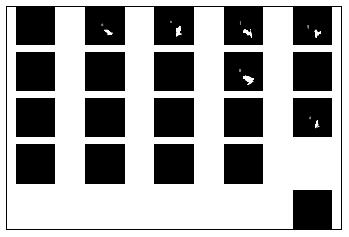

In [201]:
import matplotlib.pyplot as plt
import matplotlib.image as imgplot
import os
%matplotlib inline

#path = "/Users/oli/Proj_Large_Data/Deep_Learning_MRI/insel_annotated/ADC-contouring-test-case/3-ep2d_diff_3scan_p3_m128_ADC/iov/"
path = '/home/dueo/data/Inselspital_2015_07_08/metastasis/001_3SUIUNLJQMTGZRVTJM7LWTPHDA======/3SUIUNLJQMTGZRVTJM7LWTPHDA======-20150130-0/3-ep2d_diff_3scan_p3_m128_ADC/iov/'
fig = plt.figure()
plt.xticks([])
plt.yticks([])
files = os.listdir(path)
for i,file in enumerate(files):
    Y = readAnotations(path + file, len(file))
    a = fig.add_subplot(5, 5, i, xticks=[], yticks=[])  
    plt.imshow(Y[0,:,:], cmap=plt.get_cmap('gray'))
    print(file + ' ' + str(Y.shape) + " " + str(Y.max()))


## Creation of a list of files
##### For GBM
```
> dueo@srv-lab-t-706:~/data/Inselspital_2015_07_08/GBM
find $PWD -name '*.dcm' > ../list_GBM.txt
dueo@srv-lab-t-706:~/data/Inselspital_2015_07_08/GBM$ wc ../list_GBM.txt 
  1211   1211 274828 ../list_GBM.txt
dueo@srv-lab-t-706:~/data/Inselspital_2015_07_08/GBM$ ls -l1R | grep dcm.iov | wc
   1211   10899  142277
```
The same number of dcm.iov files as there are dcm files.

The same for metastasis.

```
dueo@srv-lab-t-706:~/data/Inselspital_2015_07_08/metastasis$ wc ../list_meta.txt 
  1223   1223 288175 ../list_meta.txt
dueo@srv-lab-t-706:~/data/Inselspital_2015_07_08/metastasis$ ls -l1R | grep dcm.iov | wc
   1119   10071  132691
```

*There are some files missing in the metastasis case*


In [164]:
import pandas as pd
dcm_files = pd.read_csv('/home/dueo/data/Inselspital_2015_07_08/list_GBM.txt', header=None)
dcm_files = dcm_files.icol(0)
type(dcm_files)

pandas.core.series.Series

### Creation of the pickeled objects

In [228]:
import os
import dicom
missing = 0
allSlices = 0 
X = np.zeros((1211,1,256,256)) #Change after all slices have been found
Y = np.zeros((1211,1,256,256))
Names = [None] * 1211
l = np.zeros(1211)
for i, fileNameAbs in dcm_files.iteritems():
    fn = os.path.basename(fileNameAbs)
    pathName = os.path.dirname(fileNameAbs)
    fnIOV = os.path.join(pathName, "iov", fn + str(".iov"))  
    if os.path.exists(fnIOV) == False:
        missing += 1
    else:
        Yp,l1 = readAnotations(fnIOV, len(fn) + 4) #We add '.iov'
        plan = dicom.read_file(fileNameAbs)
        Xp = plan.pixel_array
        dd = cv2.resize(Xp,(256,256))
        ddd = np.reshape(dd,(1,256,256))
        ##
        ## We only add if we have 256 pixel annotated in the 
        if (l1 != 256):
            print(str(np.shape(Yp)) + " " + str(np.shape(ddd)) + str(np.max(Y[:,:,:,:])))
        else:
            l[allSlices] = l1 
            X[allSlices,] = ddd
            Y[allSlices,] = Yp
            Names[allSlices] = fn
            allSlices += 1
        
print("Number of missings " + str(missing) + " Number of all slices " + str(allSlices))

---->  2  [0 1 2] 256.0
---->  2  [0 1 2] 256.0
---->  0  [0] 256.0
---->  2  [0 1 2] 256.0
---->  0  [0] 256.0
---->  0  [0] 256.0
---->  0  [0] 256.0
---->  0  [0] 256.0
---->  2  [0 1 2] 256.0
---->  0  [0] 256.0
---->  2  [0 1 2] 256.0
---->  2  [0 1 2] 256.0
---->  2  [0 1 2] 256.0
---->  0  [0] 256.0
---->  2  [0 1 2] 256.0
---->  2  [0 1 2] 256.0
---->  2  [0 1 2] 256.0
---->  0  [0] 256.0
---->  0  [0] 256.0
---->  0  [0] 256.0
---->  2  [0 1 2] 256.0
---->  2  [0 1 2] 256.0
---->  0  [0] 256.0
---->  2  [0 1 2] 256.0
---->  0  [0] 256.0
---->  0  [0] 256.0
---->  2  [0 1 2] 256.0
---->  2  [0 1 2] 256.0
---->  0  [0] 256.0
---->  2  [0 1 2] 256.0
---->  0  [0] 256.0
---->  0  [0] 256.0
---->  0  [0] 256.0
---->  2  [0 1 2] 256.0
---->  2  [0 1 2] 256.0
---->  0  [0] 256.0
---->  0  [0] 256.0
---->  2  [0 1 2] 256.0
---->  2  [0 1 2] 256.0
---->  2  [0 1 2] 256.0
---->  2  [0 1 2] 256.0
---->  2  [0 1 2] 256.0
---->  0  [0] 256.0
---->  0  [0] 256.0
---->  0  [0] 256.0
---->  0

In [232]:
import pickle
np.shape(X)
np.shape(Y)
Names[1]
maxIdx = allSlices - 1
print(maxIdx)
with open('/home/dueo/data/Inselspital_2015_07_08/GBM.pickle', 'wb') as f:
    pickle.dump((Names[0:maxIdx],X[0:maxIdx,:,:,:],Y[0:maxIdx,:,:,:],l[0:maxIdx]), f, -1)
%ls -lh /home/dueo/data/Inselspital_2015_07_08/GBM.pickle

1110
-rw-r--r-- 1 dueo dueo 1.1G Jun 25 13:42 /home/dueo/data/Inselspital_2015_07_08/GBM.pickle
